<a href="https://colab.research.google.com/github/anko191/Python_Kaggle/blob/master/Tensorflow/Boston_price_predict_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 回帰分析 Regression for tensoflow

In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
print(tf.__version__)

2.3.0


## データのダウンロード

In [10]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# Shuffle the training set
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

57344/57026 [==============================] - 0s 0us/step


In [11]:
print("Training set: {}".format(train_data.shape))
print("Testing set {}".format(test_data.shape))

Training set: (404, 13)
Testing set (102, 13)


* データセットの13の異なる特徴
    * crim/(町ごとの1人当たりの犯罪率) 低い方がいいね
    * zn/(25000平方フィート以上の住宅地の割合) めっちゃ広いやつあるって？
    * indus/(町ごとの非小売業の面積の割合) 多いほうがいい？
    * chas/チャールズ側のダミー変数(tractが川に接しているとき1, そうでない時は0) なにこれ
    * nox/NO2の濃度(1000万個当たりの) 低いほうが良い
    * rm/1住戸あたりの平均部屋数 (大きい方が良いね)
    * age/1940年以前に建てられた持ち家住宅の割合 低い方がいいのかなぁ？不明
    * dis/ボストンの5つの雇用センターまでの距離の加重平均 近いほうがいいね
    * rad/放射線状の高速道路へのアクセス性の指標　大きいほうが良い
    * tax/10000ドルあたりの全額固定資産税の税率 これなに？低いほうが良い？
    * ptratio/町別の生徒数と教師数の比率
    * black/1000(Bk-0.63)^2、bkは町ごとの黒人の割合である 0.63に近づくほど小さくなる
    * lstat/人口のステータスの低さ(percent) 人は多いほうが良いのかな～わからん
    * medv/1000ドル台の持ち家の価値の中央値 なにこれ

## (重要)リストで配列が保存されているとき、何をするか？

In [14]:
print(train_data[0])

[3.4660e-02 3.5000e+01 6.0600e+00 0.0000e+00 4.3790e-01 6.0310e+00
 2.3300e+01 6.6407e+00 1.0000e+00 3.0400e+02 1.6900e+01 3.6225e+02
 7.8300e+00]


In [15]:
import pandas as pd

In [16]:
column_names = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'black', 'lstat','medv']
df = pd.DataFrame(train_data, columns = column_names)
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,black,lstat,medv
0,0.03466,35.0,6.06,0.0,0.4379,6.031,23.3,6.6407,1.0,304.0,16.9,362.25,7.83
1,0.06076,0.0,11.93,0.0,0.5730,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
2,0.03537,34.0,6.09,0.0,0.4330,6.590,40.4,5.4917,7.0,329.0,16.1,395.75,9.50
3,0.02729,0.0,7.07,0.0,0.4690,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
4,16.81180,0.0,18.10,0.0,0.7000,5.277,98.1,1.4261,24.0,666.0,20.2,396.90,30.81


In [17]:
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,black,lstat,medv
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


## 与えられたlabelデータについて
* ラベルは数千ドル単位の住居価格(これがtarget)1970年代なかばの価格らしい

In [18]:
print(train_labels[0:10])

[19.4 23.9 22.  34.7  7.2 20.1 28.2 14.6 21.  16.8]


## 特徴を正規化する
* 全部大きさが違うよね？範囲も違うし。正規化しようや
* 、**特徴の平均を減算して標準偏差で割ればいいんだよ**

In [19]:
# testデータは使う
mean = train_data.mean(axis = 0)
std = train_data.std(axis = 0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
print(mean)

[3.74511057e+00 1.14801980e+01 1.11044307e+01 6.18811881e-02
 5.57355941e-01 6.26708168e+00 6.90106436e+01 3.74027079e+00
 9.44059406e+00 4.05898515e+02 1.84759901e+01 3.54783168e+02
 1.27408168e+01]


In [20]:
print(train_data[0])

[-0.40202987  0.99079651 -0.7415148  -0.25683275 -1.0197024  -0.33302132
 -1.63801833  1.43040316 -0.97156928 -0.61322399 -0.71712291  0.07943894
 -0.67776904]


## モデルを作成する
* 2つの隠れ層
* 単一の連続値を返すSequential モデルを使用
* model関数を作れ

In [25]:
def get_model():
    model = keras.Sequential([
                              keras.layers.Dense(64, activation = tf.nn.relu,
                                                 input_shape = (train_data.shape[1],)),
                              keras.layers.Dense(64, activation = tf.nn.relu),
                              keras.layers.Dense(1)
    ])
# optimizerの一つよ、adamとかの
# https://qiita.com/cnloni/items/ad7dcb7521b936d9fc18
# optimizer = tf.train.RMSPropOptimizer(0.001)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop
    model.compile(loss = 'mse',
                optimizer = optimizer,
                metrics = ['mae', 'acc'])
    return model
model = get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## モデルで訓練！！
* 500 epochs訓練されて、訓練と検証制度をhistory objectに記録

In [26]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end ='')
EPOCHS = 500

# Store
history = model.fit(train_data, train_labels, epochs = EPOCHS,
                    validation_split=0.2, verbose = 0,
                    callbacks = [PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [30]:
history.history.keys()

dict_keys(['loss', 'mae', 'acc', 'val_loss', 'val_mae', 'val_acc'])

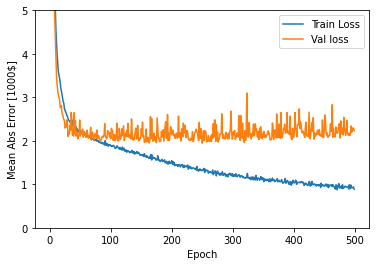

In [32]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mae']),
             label = 'Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mae']),
             label = 'Val loss')
    plt.legend()
    plt.ylim([0,5])
plot_history(history)


.....................................................

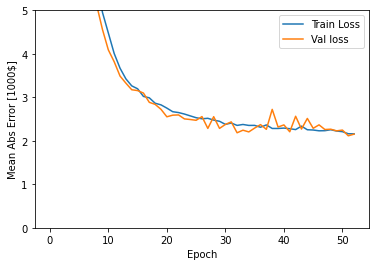

In [34]:
model = get_model()
 
# The patience parameter is the amount of epochs to check for improvement.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
 
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])
 
plot_history(history)

In [39]:
(loss, mae) = model.evaluate(test_data, test_labels, verbose=0)
 
print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

ValueError: ignored